# Topic:        Challenge Set 1  
    Subject:      Explore MTA Turnstile Data  
    Date:         01/17/2016  
    Name:         Masa Kato  
    Worked with:  N/A

### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline
import datetime
import dateutil.parser
from collections import Counter
from itertools import groupby
import calendar

## Challenge 1
* **Download MTA Turnstile Data**
* **Open & Read File with CSV Reader**
* **Create Python Dict with Keys: C/A, UNIT, SCP, STATION; Values: List of Lists of All Other Columns**

In [2]:
def read_data(filename):
    file = open(filename)
    csv_data = csv.reader(file)
    data = []
    for row in csv_data:
        # Remove Unnecessary Whitespace
        row[-1] = row[-1].strip()
        data.append(row)
    col_names = data.pop(0)
    file.close()
    return data
data = read_data('turnstile_170107.txt')

# Only use first 10000 datapoints for computation
data = data[0:10000]

In [3]:
# Preview Data
print('First Row of Data:',data[0])
print('Number of Rows:',len(data))

First Row of Data: ['A002', 'R051', '02-00-00', '59 ST', 'NQR456W', 'BMT', '12/31/2016', '03:00:00', 'REGULAR', '0005991546', '0002028378']
Number of Rows: 10000


In [4]:
def create_dict(data):
    mta_dict = {}
    for row in data:
        key, value = tuple(row[0:4]), row[4:]
        mta_dict.setdefault(key, []).append(value)
    return mta_dict
mta_dict = create_dict(data)

In [5]:
# Preview Data
sample_key = tuple(data[0][0:4])
print('Sample Key:',sample_key)
print('Sample Value:',mta_dict[sample_key][0])

Sample Key: ('A002', 'R051', '02-00-00', '59 ST')
Sample Value: ['NQR456W', 'BMT', '12/31/2016', '03:00:00', 'REGULAR', '0005991546', '0002028378']


## Challenge 2
* **Create Python Dict with Keys: C/A, UNIT, SCP, STATION; Values: List of Lists of Datetime & Entries**
* **Combine Date and Time into a string & use the dateutil module to convert to datetime object**

In [6]:
def create_time_dict(data):
    '''
    Input: Data from read_data
    '''
    time_dict = {}
    for row in data:
        key = tuple(row[0:4])
        # Date : Column 6, Time : Column 7, Entries : Column 9
        date, time, entry = row[6], row[7], row[9]
        datetime = dateutil.parser.parse(date + ' ' + time)
        value = [datetime, int(entry)]
        time_dict.setdefault(key, []).append(value)
    return time_dict
time_dict = create_time_dict(data)

In [7]:
# Preview Data
sample_key = tuple(data[0][0:4])
print('Sample Key:',sample_key)
print('Sample Value:',time_dict[sample_key][0:5])

Sample Key: ('A002', 'R051', '02-00-00', '59 ST')
Sample Value: [[datetime.datetime(2016, 12, 31, 3, 0), 5991546], [datetime.datetime(2016, 12, 31, 7, 0), 5991565], [datetime.datetime(2016, 12, 31, 11, 0), 5991644], [datetime.datetime(2016, 12, 31, 15, 0), 5991971], [datetime.datetime(2016, 12, 31, 19, 0), 5992418]]


## Challenge 3
* **Create Python Dict similar to Challenge 2 except with a single value of total daily entries for each day**

In [8]:
def create_count_dict(time_dict):
    '''
    Input: Dictionary created in create_time_dict
    '''
    count_dict = {}
    for key , value in time_dict.items():
        unique_dates = sorted(set([date_entry[0].date() for date_entry in value]))
        for date in unique_dates:
            # List of Entries per 4 Hour Intervals on Given Date
            entries_for_day = [date_entry[1] for date_entry in value if date_entry[0].date() == date]
            # Compute Total Number of Entries on Given Date
            entries_total = max(entries_for_day) - min(entries_for_day)
            count_dict.setdefault(key, []).append([date, entries_total])
    return count_dict
count_dict = create_count_dict(time_dict)
count_dict = create_count_dict(time_dict)

In [9]:
# Preview Data
sample_key = tuple(data[0][0:4])
print('Sample Key:',sample_key)
print('Sample Value:',count_dict[sample_key][0:5])

Sample Key: ('A002', 'R051', '02-00-00', '59 ST')
Sample Value: [[datetime.date(2016, 12, 31), 1092], [datetime.date(2017, 1, 1), 797], [datetime.date(2017, 1, 2), 907], [datetime.date(2017, 1, 3), 1715], [datetime.date(2017, 1, 4), 1602]]


## Challenge 4
* **Plot daily time series for turnstile**

In [10]:
# A sample turnstile key
turnstile_key = ('A002', 'R051', '02-00-00', '59 ST') # Same as tuple(data[0][0:4])

In [11]:
def plot_timeseries(count_dict, turnstile):
    '''
    Input: Dictionary created in create_count_dict & key for particular turnstile - ie. ('A002', 'R051', '02-00-00', '59 ST')
    '''
    data = count_dict[turnstile]
    dates = [item[0] for item in data]
    count = [item[1] for item in data]
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(dates, count)
    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Count',fontsize=12)
    plt.title(str(turnstile[3]) + '- Single Turnstile',fontsize=18)

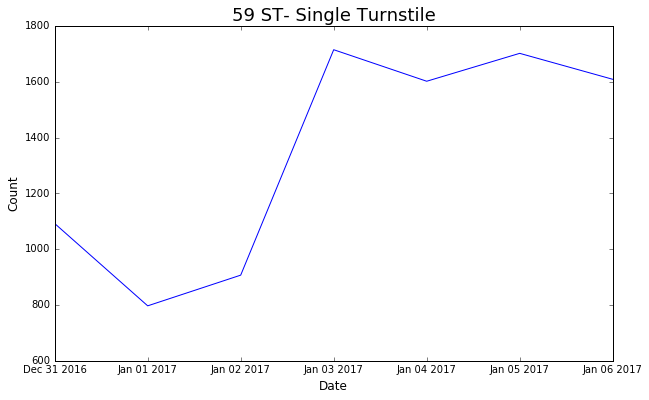

In [12]:
plot_timeseries(count_dict, turnstile_key)

## Challenge 5
* **Combine turnstiles in the same ControlArea/Unit/Station**

### Original Approach  
**Notice format of key is not consistent with previous challenge results. See alternative approach below for correct formatting**

In [13]:
def mult_counts(count_dict):
    '''
    Input: Dictionary created in create_count_dict
    '''
    grouped_count = {}
    for key, values in count_dict.items():
        CA, Unit, Station = key[0], key[1], key[3]
        grouped_count[(CA, Unit, Station)] = grouped_count.get((CA, Unit, Station), Counter())

        for date, count in values:
            grouped_count[(CA, Unit, Station)][date] += count
            
    return grouped_count

multiple_counts = mult_counts(count_dict)

In [14]:
# Preview Data
sample_key = ('A037', 'R170', '14 ST-UNION SQ')
print('Sample Key:',sample_key)
print('Sample Value:', multiple_counts[sample_key])

Sample Key: ('A037', 'R170', '14 ST-UNION SQ')
Sample Value: Counter({datetime.date(2017, 1, 4): 13546, datetime.date(2017, 1, 6): 13518, datetime.date(2017, 1, 5): 13124, datetime.date(2017, 1, 3): 12861, datetime.date(2016, 12, 31): 9832, datetime.date(2017, 1, 2): 9549, datetime.date(2017, 1, 1): 7020})


### Alternative Approach - Outputs Correct Formatting

In [15]:
def mult_counts_alt(count_dict):
    '''
    Input: Dictionary created in create_count_dict
    '''
    grouped_count = {}
    
    sorted_dict = sorted(count_dict.items())
    for key, value in groupby(sorted_dict, key=lambda x: (x[0][0],x[0][1],x[0][3])):
        # key = (CA, Unit, Station)
        # value = Grouper Object
        counter = Counter()
        for _, date_list in value:
            for date, count in date_list:
                counter[date] += count
        
        # grouped_count[key] = sorted(counter.items())
        # Commented code above works as well but the following reformats list of tuples into list of lists
        grouped_count[key] = [[date,count] for date, count in sorted(counter.items())]
    return grouped_count
multiple_counts_alt = mult_counts_alt(count_dict)

In [16]:
# Preview Data
sample_key = ('A037', 'R170', '14 ST-UNION SQ')
print('Sample Key:',sample_key)
print('Sample Value:', multiple_counts_alt[sample_key])

Sample Key: ('A037', 'R170', '14 ST-UNION SQ')
Sample Value: [[datetime.date(2016, 12, 31), 9832], [datetime.date(2017, 1, 1), 7020], [datetime.date(2017, 1, 2), 9549], [datetime.date(2017, 1, 3), 12861], [datetime.date(2017, 1, 4), 13546], [datetime.date(2017, 1, 5), 13124], [datetime.date(2017, 1, 6), 13518]]


# Challenge 6
* **Combine all counts for one station**

### Original Approach  
**Notice format of key is not consistent with ```[(date1, count1),(date2,count2),...]``` specified in problem prompt. See alternative approach below for correct formatting**

In [17]:
def counts_per_station(detailed_counts):
    '''
    Input: Dictionary created in mult_counts
    '''
    station_counts = {}
    for key, values in detailed_counts.items():
        Station = key[2]
        station_counts[Station] = station_counts.get(Station, Counter())
        for date, count in values.items():
            station_counts[Station][date] += count
    return station_counts

station_counts = counts_per_station(multiple_counts)

In [18]:
# Preview Data
sample_key = ('14 ST-UNION SQ')
print('Sample Key:',sample_key)
print('Sample Value:', station_counts[sample_key])

Sample Key: 14 ST-UNION SQ
Sample Value: Counter({datetime.date(2017, 1, 4): 59009, datetime.date(2017, 1, 6): 57679, datetime.date(2017, 1, 5): 57437, datetime.date(2017, 1, 3): 52496, datetime.date(2016, 12, 31): 32417, datetime.date(2017, 1, 2): 29445, datetime.date(2017, 1, 1): 24821})


### Alternative Approach - Outputs Correct Formatting

In [19]:
def counts_per_station_alt(detailed_counts):
    '''
    Input: Dictionary created in mult_counts_alt
    '''
    grouped_count = {}
    
    sorted_dict = sorted(detailed_counts.items())
    for key, value in groupby(sorted_dict, key=lambda x: x[0][2]):
        # key = Station Name
        # value = Grouper Object
        counter = Counter()
        for _, date_list in value:
            for date, count in date_list:
                counter[date] += count
                
        grouped_count[key] = sorted(counter.items())
    return grouped_count
station_counts_alt = counts_per_station_alt(multiple_counts_alt)

In [20]:
# Preview Data
sample_key = ('14 ST-UNION SQ')
print('Sample Key:',sample_key)
print('Sample Value:', station_counts_alt[sample_key])

Sample Key: 14 ST-UNION SQ
Sample Value: [(datetime.date(2016, 12, 31), 32417), (datetime.date(2017, 1, 1), 24821), (datetime.date(2017, 1, 2), 29445), (datetime.date(2017, 1, 3), 52496), (datetime.date(2017, 1, 4), 59009), (datetime.date(2017, 1, 5), 57437), (datetime.date(2017, 1, 6), 57679)]


# Challenge 7
* **Plot the time series for a station**

In [21]:
# A sample station
sample_station = ('14 ST-UNION SQ')

In [22]:
def plot_station_timeseries(station_dict,station_name):
    '''
    Input: Dictionary created in counts_per_station_alt and a particular station name - ie. (14 ST-UNION SQ)
    '''
    data = station_dict[station_name]

    dates = [item[0] for item in data]
    count = [item[1] for item in data]
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.plot(dates, count)
    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Count',fontsize=12)
    plt.title('Counts at '+str(station_name),fontsize=18)

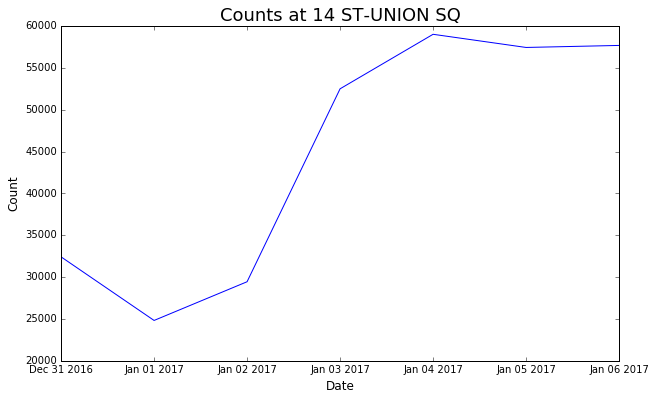

In [23]:
plot_station_timeseries(station_counts_alt, sample_station)

# Challenge 8
* **Make a list of counts for each day of the week for a particular station**
* **Make the same list for four weeks**
* **Plot the count for each week**

In [24]:
# Read each data file for four weeks
data_161217 = read_data('turnstile_161217.txt')
data_161224 = read_data('turnstile_161224.txt')
data_161231 = read_data('turnstile_161231.txt')
data_170107 = read_data('turnstile_170107.txt')

In [25]:
# Use only the first 10000 rows of each data
# data_161217 = data_161217[:10000]
# data_161224 = data_161224[:10000]
# data_161231 = data_161231[:10000]
# data_170107 = data_170107[:10000]

In [26]:
# Call create_dict function to each data set
# Input = Data File
# Output = Python Dict with Keys: C/A, UNIT, SCP, STATION; Values: List of Lists of Datetime & Entries
time_dict_161217 = create_time_dict(data_161217)
time_dict_161224 = create_time_dict(data_161224)
time_dict_161231 = create_time_dict(data_161231)
time_dict_170107 = create_time_dict(data_170107)

In [27]:
# Call create_count_dict function to each dictionary
# Input: Dictionary created in create_time_dict
# Output: Dictionary with a single value of total daily entries for each day
count_dict_161217 = create_count_dict(time_dict_161217)
count_dict_161224 = create_count_dict(time_dict_161224)
count_dict_161231 = create_count_dict(time_dict_161231)
count_dict_170107 = create_count_dict(time_dict_170107)

In [28]:
# Call mult_counts_alt to each dictionary
# Input: Dictionary created in create_count_dict
# Output: Dictionary with combined turnstiles in the same ControlArea/Unit/Station
multiple_counts_161217 = mult_counts_alt(count_dict_161217)
multiple_counts_161224 = mult_counts_alt(count_dict_161224)
multiple_counts_161231 = mult_counts_alt(count_dict_161231)
multiple_counts_170107 = mult_counts_alt(count_dict_170107)

In [29]:
# Call counts_per_station_alt to each dictionary
# Input: Dictionary created in mult_counts
# Output: Dictionary with combined counts in the same station
station_counts_161217 = counts_per_station_alt(multiple_counts_161217)
station_counts_161224 = counts_per_station_alt(multiple_counts_161224)
station_counts_161231 = counts_per_station_alt(multiple_counts_161231)
station_counts_170107 = counts_per_station_alt(multiple_counts_170107)

In [30]:
def convert_date_to_weekday(dict_keys):
    '''
    Input: Values for a specific station from counts_per_station_alt dictionary
    Output: List of Lists of Day of Week and Corresponding Count
    '''
    weekday_count = []
    for datetime,count in dict_keys:
        weekday_count.append([calendar.day_name[datetime.weekday()],count])
    
    return weekday_count

In [31]:
# Assign Keys from station_counts dicts to pass to convert_date_to_weekday function
keys_161217 = station_counts_161217[sample_key]
keys_161224 = station_counts_161224[sample_key]
keys_161231 = station_counts_161231[sample_key]
keys_170107 = station_counts_170107[sample_key]

In [32]:
# Convert Datetime to Day of the Week
day_count_161217 = convert_date_to_weekday(keys_161217)
day_count_161224 = convert_date_to_weekday(keys_161224)
day_count_161231 = convert_date_to_weekday(keys_161231)
day_count_170107 = convert_date_to_weekday(keys_170107)

In [33]:
# Station that we are investigating
sample_key = ('14 ST-UNION SQ')

# Create a List of day_count lists
day_counts = [day_count_161217, day_count_161224, day_count_161231, day_count_170107]

# Create a List of Dates to Pass to plot_weekday_counts
week_list = ['Dec 17, 2016', 'Dec 24, 2016','Dec 31, 2016','Jan 07, 2016']

In [34]:
def plot_weekday_counts(day_count,week_list, station_name):
    '''
    Input: day_count - List of day_count lists created in convert_date_to_weekday
           week_list - List of the particular weeks included in date_count ie. ['Dec 17, 2016', 'Dec 24, 2016', etc]
           station_name - Name of station corresponding to the values in day_count
    '''
    
    # Plot
    plt.figure(figsize=(10,6))
    plt.xlabel('Weekday',fontsize=12)
    plt.ylabel('Count',fontsize=12)
    plt.title('Counts at '+str(station_name),fontsize=18)
    
    index = 0
    for week in day_count:
        ticks = [day_count[0] for day_count in week]
        days = [1,2,3,4,5,6,7]
        counts = [day_count[1] for day_count in week]
        plt.plot(days,counts, label=week_list[index])
        index+=1
        plt.xticks(days, ticks, rotation='vertical')
    plt.legend(loc='lower right')

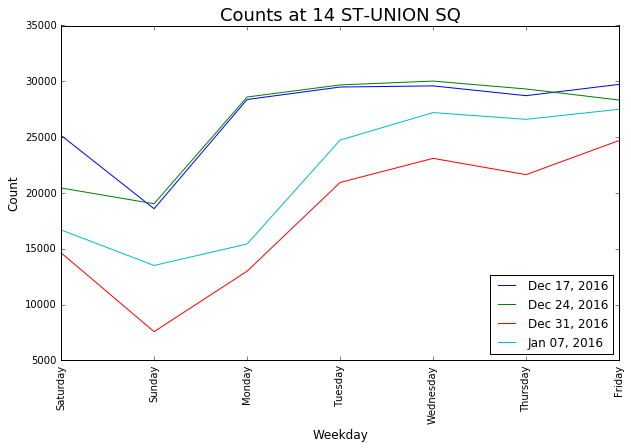

In [35]:
plot_weekday_counts(day_counts, week_list, sample_key)

# Challenge 9
* **Over multiple weeks, sum total ridership for each station and sort by count**

In [36]:
def count_total(station_counts):
    '''
    Input: Dictionary of station_counts created by counts_per_station_alt
    '''
    total_counts = {}
    
    for key, value in station_counts.items():
        running_count = 0
        for date, count in value:
            running_count += count

        total_counts[key] = running_count
    return total_counts

In [37]:
total_count_161217 = count_total(station_counts_161217)
total_count_161224 = count_total(station_counts_161224)
total_count_161231 = count_total(station_counts_161231)
total_count_170107 = count_total(station_counts_170107)

In [47]:
# Preview Data
sorted(total_count_161217.items(), key=lambda x: x[1],reverse=True)

[('AVENUE J', 16811773),
 ('69 ST', 9093913),
 ('GRD CNTRL-42 ST', 916949),
 ('42 ST-PORT AUTH', 611422),
 ('34 ST-PENN STA', 561723),
 ('TIMES SQ-42 ST', 511852),
 ('34 ST-HERALD SQ', 510701),
 ('47-50 STS ROCK', 418308),
 ('86 ST', 410658),
 ('FLUSHING-MAIN', 364748),
 ('59 ST', 312330),
 ('JKSN HT-ROOSVLT', 304116),
 ('LEXINGTON AV/53', 268810),
 ('EXCHANGE PLACE', 265068),
 ('42 ST-BRYANT PK', 261196),
 ('JAY ST-METROTEC', 251860),
 ('JAMAICA CENTER', 244646),
 ('72 ST', 231657),
 ('W 4 ST-WASH SQ', 216447),
 ('BOROUGH HALL', 211972),
 ('77 ST', 210769),
 ('ATL AV-BARCLAY', 209098),
 ('CROWN HTS-UTICA', 196814),
 ('68ST-HUNTER CO', 193155),
 ('57 ST-7 AV', 192911),
 ('14 ST-UNION SQ', 189616),
 ('BOWLING GREEN', 183478),
 ('BEDFORD AV', 179624),
 ('33 ST', 174978),
 ('50 ST', 172836),
 ('49 ST', 169241),
 ('LACKAWANNA', 168620),
 ('FOREST HILLS 71', 161938),
 ('23 ST', 160019),
 ('KEW GARDENS', 157308),
 ('5 AV/53 ST', 157241),
 ('14 ST', 156355),
 ('96 ST', 154515),
 ('GRAND ST', 

# Challenge 10
* **Make a single list of these total ridership values and plot it with**

In [49]:
# Create a list of total_counts for every week
total_list = [total_count_161217,total_count_161224,total_count_161231,total_count_170107]

[{'1 AV': 142190,
  '103 ST': 95854,
  '103 ST-CORONA': 126112,
  '104 ST': 11246,
  '110 ST': 79723,
  '111 ST': 72078,
  '116 ST': 71712,
  '116 ST-COLUMBIA': 84633,
  '121 ST': 14682,
  '125 ST': 91237,
  '135 ST': 95612,
  '137 ST CITY COL': 85082,
  '138/GRAND CONC': 21151,
  '14 ST': 156355,
  '14 ST-UNION SQ': 189616,
  '145 ST': 22727,
  '149/GRAND CONC': 87381,
  '14TH STREET': 41762,
  '15 ST-PROSPECT': 39538,
  '155 ST': 24263,
  '157 ST': 67454,
  '161/YANKEE STAD': 51563,
  '163 ST-AMSTERDM': 27970,
  '167 ST': 60808,
  '168 ST': 80758,
  '169 ST': 54012,
  '170 ST': 57229,
  '174 ST': 44481,
  '174-175 STS': 33823,
  '175 ST': 81205,
  '176 ST': 39696,
  '18 AV': 21869,
  '18 ST': 58249,
  '181 ST': 76946,
  '182-183 STS': 32753,
  '183 ST': 40140,
  '190 ST': 29397,
  '191 ST': 56636,
  '2 AV': 111668,
  '20 AV': 29401,
  '207 ST': 43125,
  '21 ST': 10137,
  '21 ST-QNSBRIDGE': 55514,
  '215 ST': 12448,
  '219 ST': 20534,
  '225 ST': 26425,
  '23 ST': 160019,
  '231 ST': 

In [40]:
def count_total_mult_weeks(list_of_total_dicts):
    '''
    Input: List of Dicts created in count_total
    Output: A single dict of the total counts for each station over multiple weeks
    '''
    weeks_total = {}
    for total_counts in list_of_total_dicts:
        for station, count in total_counts.items():
            weeks_total[station] = weeks_total.get(station,0) + count
    return weeks_total
station_totals_mult_weeks = count_total_mult_weeks(total_list)

In [67]:
# Preview
sorted_totals = sorted(station_totals_mult_weeks.items(), key=lambda x: x[1],reverse=True)

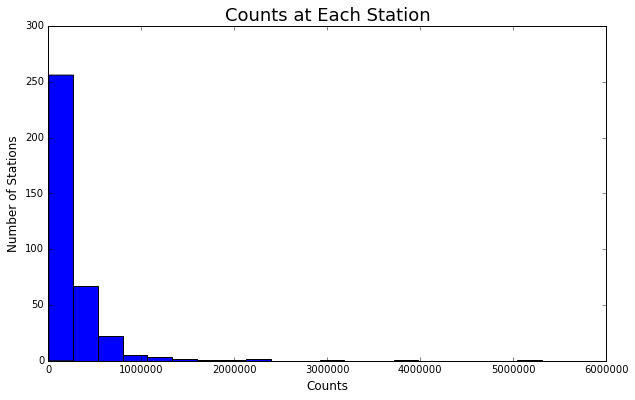

In [79]:
def plot_station_totals(input_list):
    stations = [item[0] for item in input_list]
    counts = [item[1] for item in input_list]
    plt.figure(figsize=(10,6))
    plt.hist(counts, bins=20)
    plt.xlabel('Counts',fontsize=12)
    plt.ylabel('Number of Stations',fontsize=12)
    plt.title('Counts at Each Station',fontsize=18)
plot_station_totals(sorted_totals[10:])